## Data Summary

Second part of the exercise:

> Create a brief report that summarizes the core features of the data and calls out interesting trends, etc. This can be in the form of a notebook-like document (Jupyter, RMarkdown, etc.) or a slide deck. The audience for this should be other data scientists who need to understand that dataset.

In [1]:
library(tidyverse)

df <- read_csv('data/030611-2017_trips.csv')

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.0.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.6
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Parsed with column specification:
cols(
  VendorID = col_integer(),
  tpep_pickup_datetime = col_datetime(format = ""),
  tpep_dropoff_datetime = col_datetime(format = ""),
  passenger_count = col_integer(),
  trip_distance = col_double(),
  RatecodeID = col_integer(),
  store_and_fwd_flag = col_character(),
  PULocationID = col_integer(),
  DOLocationID = col_integer(),
  payment_type = col_integer(),
  fare_amount = col_double(),
  extra = col_double(),
  mta_tax = col_double(),
  tip_amount = col_double(),
  tolls_amount = col_double(),
  improvement_surcharge = col_double(),
  total_amount = col_double()
)

In [2]:
summary(df)

    VendorID     tpep_pickup_datetime          tpep_dropoff_datetime        
 Min.   :1.000   Min.   :2017-03-01 00:00:00   Min.   :2017-03-01 00:00:00  
 1st Qu.:1.000   1st Qu.:2017-03-23 06:52:43   1st Qu.:2017-03-23 07:04:35  
 Median :2.000   Median :2017-06-14 07:51:37   Median :2017-06-14 08:05:22  
 Mean   :1.546   Mean   :2017-07-02 02:57:31   Mean   :2017-07-02 03:14:26  
 3rd Qu.:2.000   3rd Qu.:2017-11-07 05:30:20   3rd Qu.:2017-11-07 05:47:45  
 Max.   :2.000   Max.   :2017-11-30 23:59:59   Max.   :2019-04-24 19:21:54  
 passenger_count trip_distance        RatecodeID     store_and_fwd_flag
 Min.   :0.000   Min.   :   0.000   Min.   : 1.000   Length:29236103   
 1st Qu.:1.000   1st Qu.:   0.970   1st Qu.: 1.000   Class :character  
 Median :1.000   Median :   1.600   Median : 1.000   Mode  :character  
 Mean   :1.618   Mean   :   2.919   Mean   : 1.043                     
 3rd Qu.:2.000   3rd Qu.:   3.010   3rd Qu.: 1.000                     
 Max.   :9.000   Max.   :9496

### Dates

Add date and hour variables for further time series exploration.

In [3]:
library(lubridate)
df <- df %>%
    mutate(PUdate = date(tpep_pickup_datetime), 
           PUhour = hour(tpep_pickup_datetime),
           DOdate = date(tpep_dropoff_datetime), 
           DOhour = hour(tpep_dropoff_datetime), 
           trip_duration = as.numeric(difftime(tpep_dropoff_datetime,tpep_pickup_datetime,units="mins")))
summary(df$trip_duration)


Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date



    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
 -4280.3      6.7     11.3     16.9     18.7 757771.7 

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


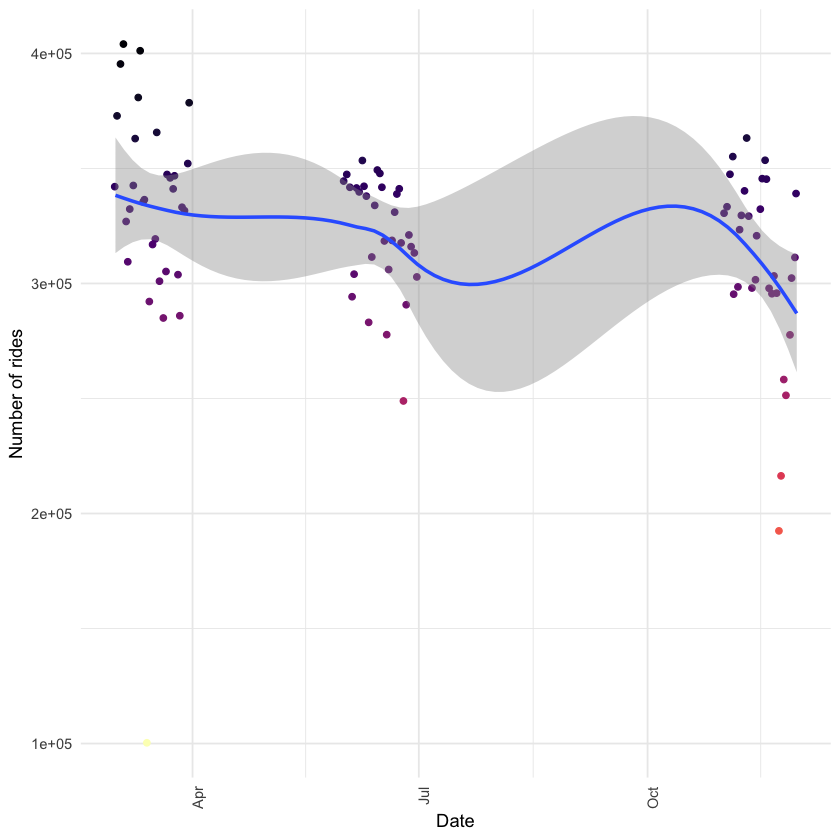

In [13]:
library(viridis)
ggplot(df %>% group_by(PUdate) %>% summarise(n = n()), aes(x = PUdate, y = n)) +
    geom_jitter(aes(color = n)) + 
    geom_smooth() +
    theme_minimal() + 
    scale_color_viridis(option = 'magma', direction = -1) +
    theme(axis.text.x = element_text(angle = 90, hjust = 1),
         legend.position = 'none') +
    labs(x = 'Date', y = 'Number of rides')

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


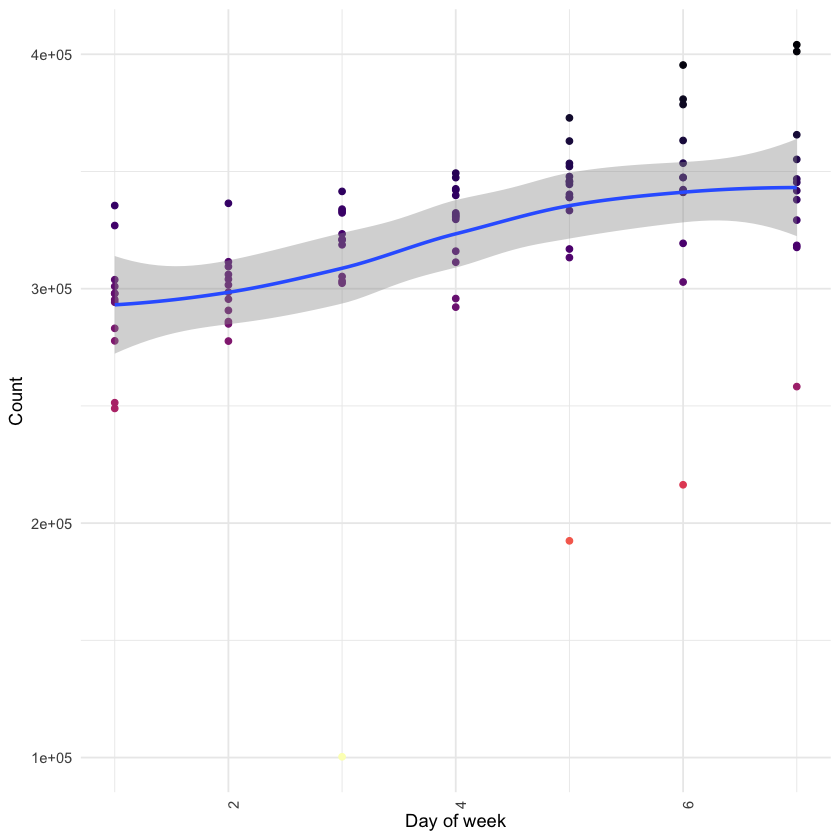

In [5]:
ggplot(df %>% group_by(PUdate) %>% summarise(n = n()), aes(x = wday(PUdate), y = n)) + 
    geom_point(aes(color = n)) + 
    geom_smooth() +
    theme_minimal() + 
    scale_color_viridis(option="magma", direction = -1) +
    theme(axis.text.x = element_text(angle = 90, hjust = 1),
         legend.position="none") +
    labs(x = "Day of week", y = "Count")

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


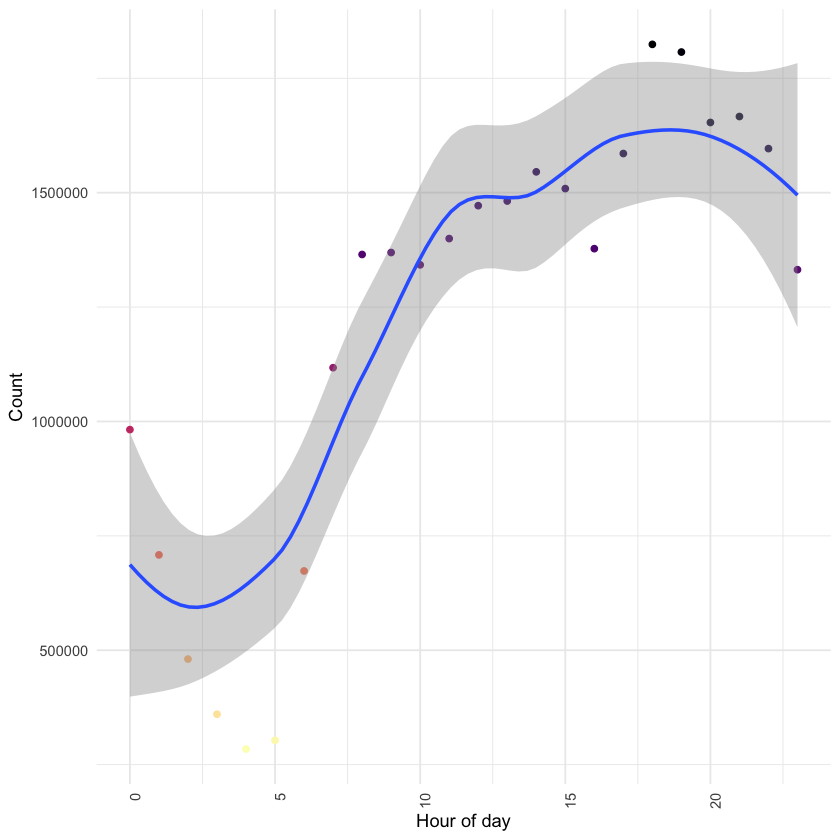

In [6]:
ggplot(df %>% group_by(PUhour) %>% summarise(n = n()), aes(x = PUhour, y = n)) + 
    geom_point(aes(color = n)) + 
    geom_smooth() +
    theme_minimal() + 
    scale_color_viridis(option="magma", direction = -1) +
    theme(axis.text.x = element_text(angle = 90, hjust = 1),
         legend.position="none") +
    labs(x = "Hour of day", y = "Count")

### Number of passengers

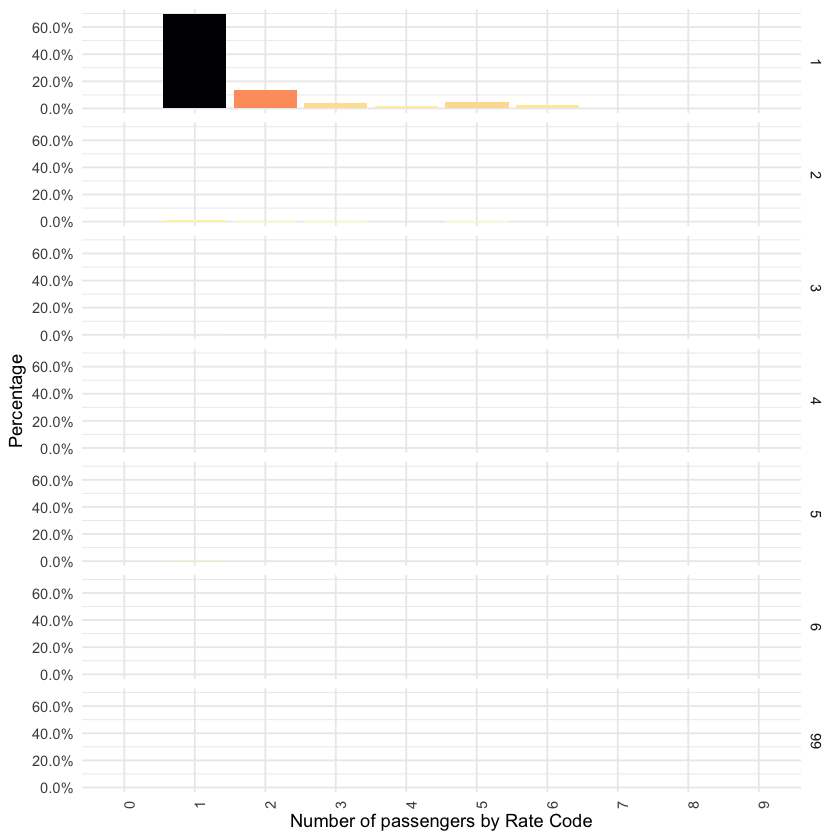

In [7]:
ggplot(df, aes(x = as.factor(passenger_count))) +  
    geom_bar(aes(y = (..count..)/sum(..count..), fill = (..count..)/sum(..count..))) + 
    scale_y_continuous(labels=scales::percent) +
    theme_minimal() + 
    scale_fill_viridis(option="magma", direction = -1) +
    theme(axis.text.x = element_text(angle = 90, hjust = 1),
         legend.position="none") +
    labs(x = "Number of passengers by Rate Code", y = "Percentage") + 
    facet_grid(rows = vars(RatecodeID))

### Correlations

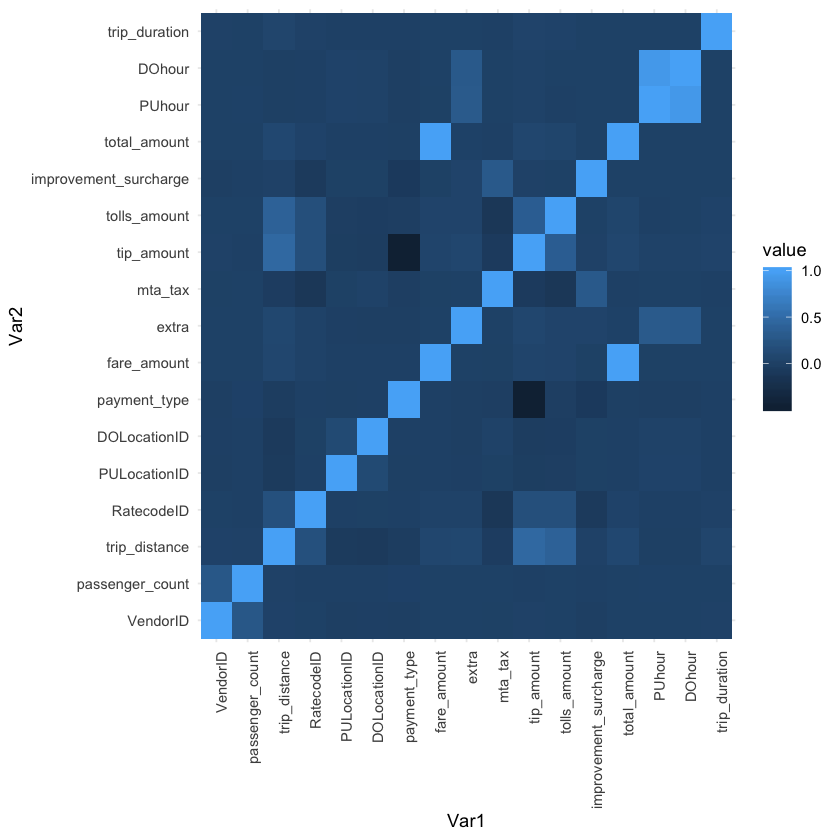

In [8]:
cormat <- cor(df %>% select(-c('store_and_fwd_flag', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'DOdate', 'PUdate')))
melted_cormat <- reshape2::melt(cormat)
ggplot(data = melted_cormat, aes(x=Var1, y=Var2, fill=value)) + 
  geom_tile() +
  theme_minimal() + 
  theme(axis.text.x = element_text(angle = 90, hjust = 1))

### Tips

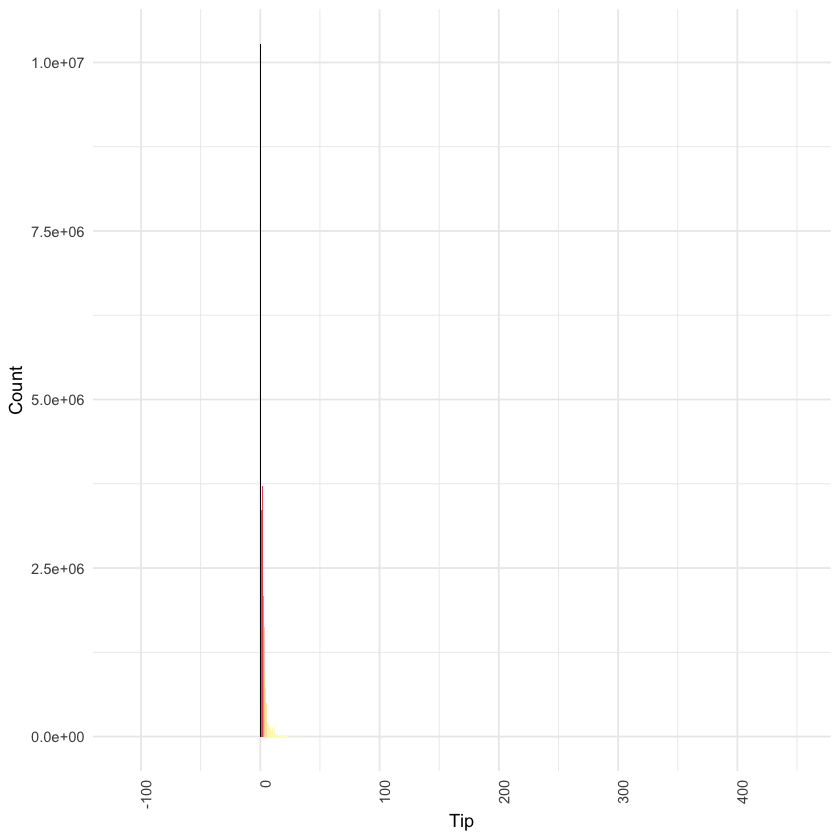

In [9]:
ggplot(df %>% select(tip_amount), aes(x = tip_amount)) + 
    geom_histogram(binwidth = 0.5, aes(fill=(..count..))) +
    theme_minimal() + 
    theme(axis.text.x = element_text(angle = 90, hjust = 1),
         legend.position="none") +
    scale_fill_viridis(option="magma", direction = -1) +
    labs(x = "Tip", y = "Count")

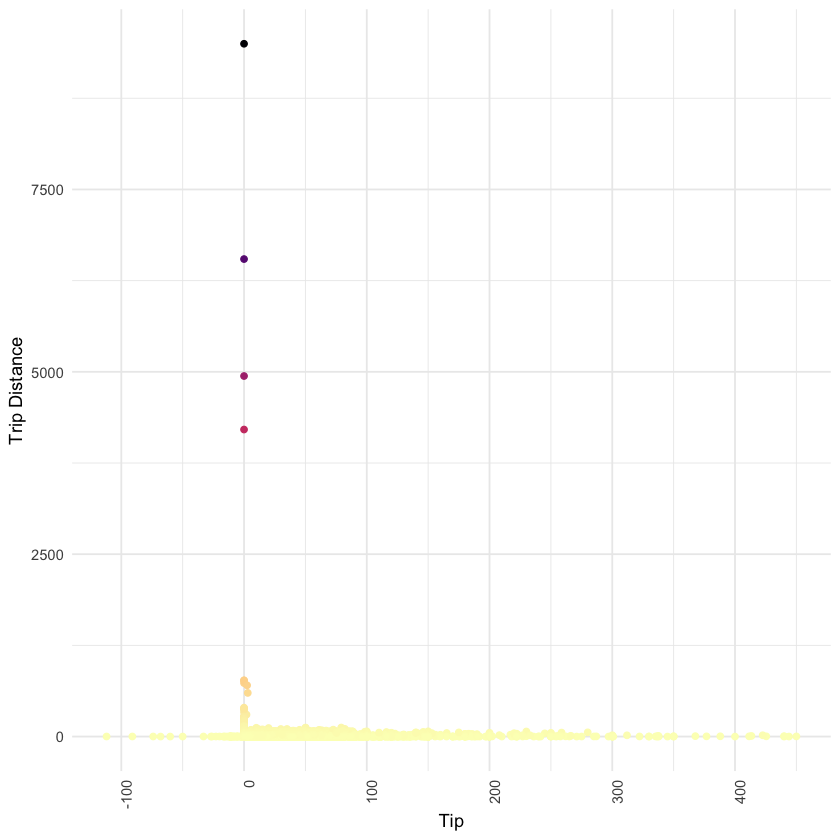

In [10]:
ggplot(df, aes(x = tip_amount)) + 
    geom_point(aes(y = trip_distance, color = trip_distance)) +
    theme_minimal() + 
    scale_color_viridis(option="magma", direction = -1) +
    theme(axis.text.x = element_text(angle = 90, hjust = 1),
         legend.position="none") +
    labs(x = "Tip", y = "Trip Distance")

In [13]:
write_csv(df, 'data/data_new-vars.csv')